# Set Cover problem

In [952]:
import numpy as np
from itertools import accumulate
from matplotlib import pyplot as plt
from icecream import ic

## Set Cover Problem - Global code


In [953]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [954]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [955]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness_plot(fitness_values):
    plt.figure(figsize=(14, 8))
    plt.plot(
       range(len(fitness_values)),
       list(accumulate(fitness_values, max)),
       color="red",
    )
    _ = plt.scatter(range(len(fitness_values)), fitness_values, marker=".")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.title("Hill Climbing Fitness Over Iterations")
    plt.show()

## First dumb solutions

In [956]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(4280968.530675888)


In [957]:
# A random solution with random 50% of the sets --> could be invalid
solution = np.random.random(NUM_SETS) < 0.5
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(1971253.0004140886)


## Hill Climbing - main utility functions

In [958]:
# First simple tweak: add/remove a random set
# SINGLE MUTATION
def tweak_1(solution):
    """Tweaks a solution by adding/removing a random set"""
    new_solution = solution.copy()
    index = rng.integers(NUM_SETS)
    new_solution[index] = not new_solution[index]
    return new_solution

# Improved tweak: iterate with a 40% of chance of a new step
# MULTPLE MUTATIONS 
def tweak_2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or rng.random() < 0.4:
        index = rng.integers(NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

def fitness_1(solution):
    """Returns the fitness of a solution in terms of (validity, -cost)"""
    return (valid(solution), -cost(solution))

def fitness_2(solution):
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    return (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))

# Starting point: all sets taken
def starting_point_1():
    return rng.random(NUM_SETS) < 1

# Starting point: chance of 1% for each set to be taken
def starting_point_2():
    return rng.random(NUM_SETS) < 0.01

# Define a fixed number of steps as a stopping criterion
def stopping_criterion():
    NUM_STEPS = 400
    return range(NUM_STEPS)

### Hill Climbing - Single random mutation

#### Single random mutation with first fitness and starting point

In [959]:
# A simple hill-climbing algorithm
def hill_climbing(tweak, fitness, starting_point):
    solution = starting_point()
    history = [fitness(solution)]
    for _ in stopping_criterion():
        new_solution = tweak(solution)
        history.append(fitness(new_solution))
        if fitness(new_solution) > fitness(solution):
            solution = new_solution
    return solution, history


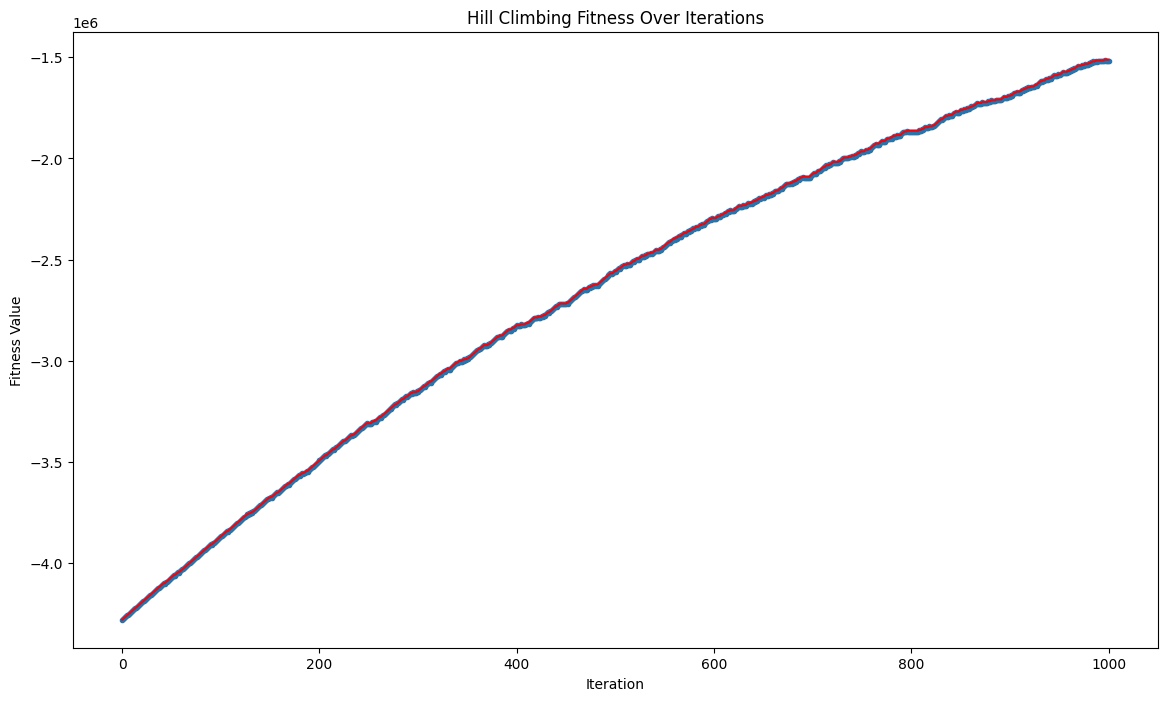

ic| valid(s): np.True_, cost(s): np.float64(1511913.2647468885)


In [960]:
s, history = hill_climbing(tweak=tweak_1, fitness=fitness_1, starting_point=starting_point_1)

fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None

#### Single random mutation with second fitness and starting point

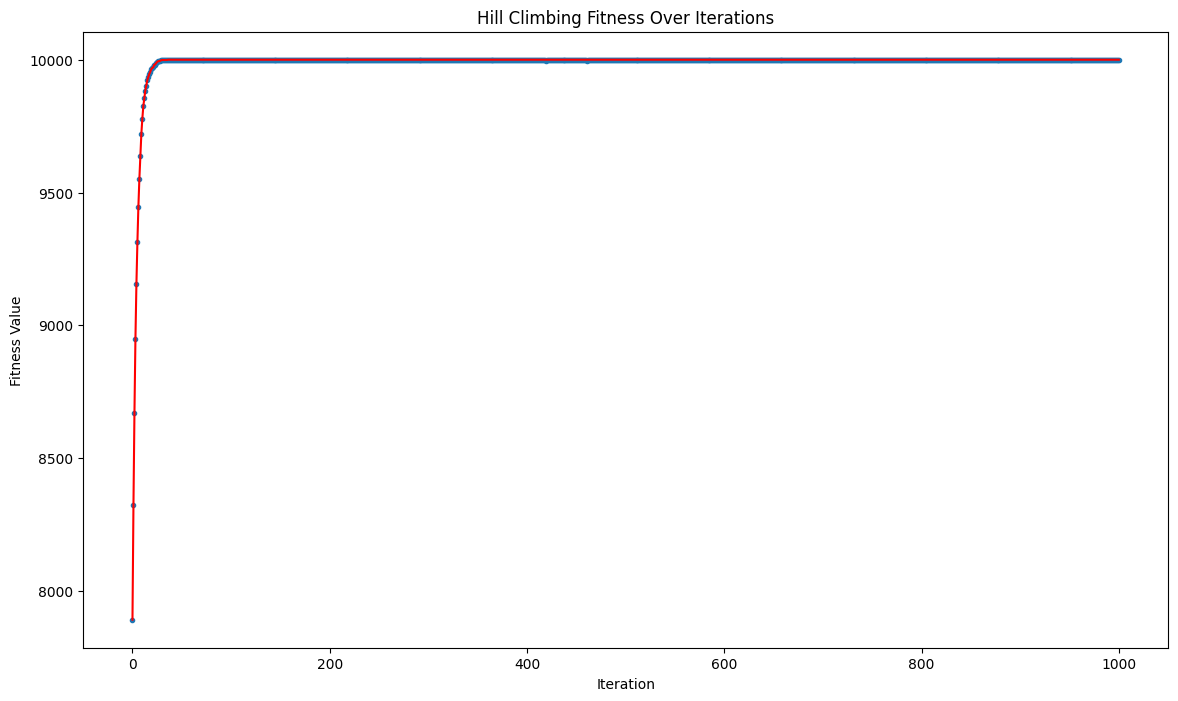

ic| valid(s): np.True_, cost(s): np.float64(132520.86886206)


In [967]:
s, history = hill_climbing(tweak=tweak_1, fitness=fitness_2, starting_point=starting_point_2)

fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None

### Hill Climbing - Multiple random mutations

#### Multiple random mutations with first fitness and starting point

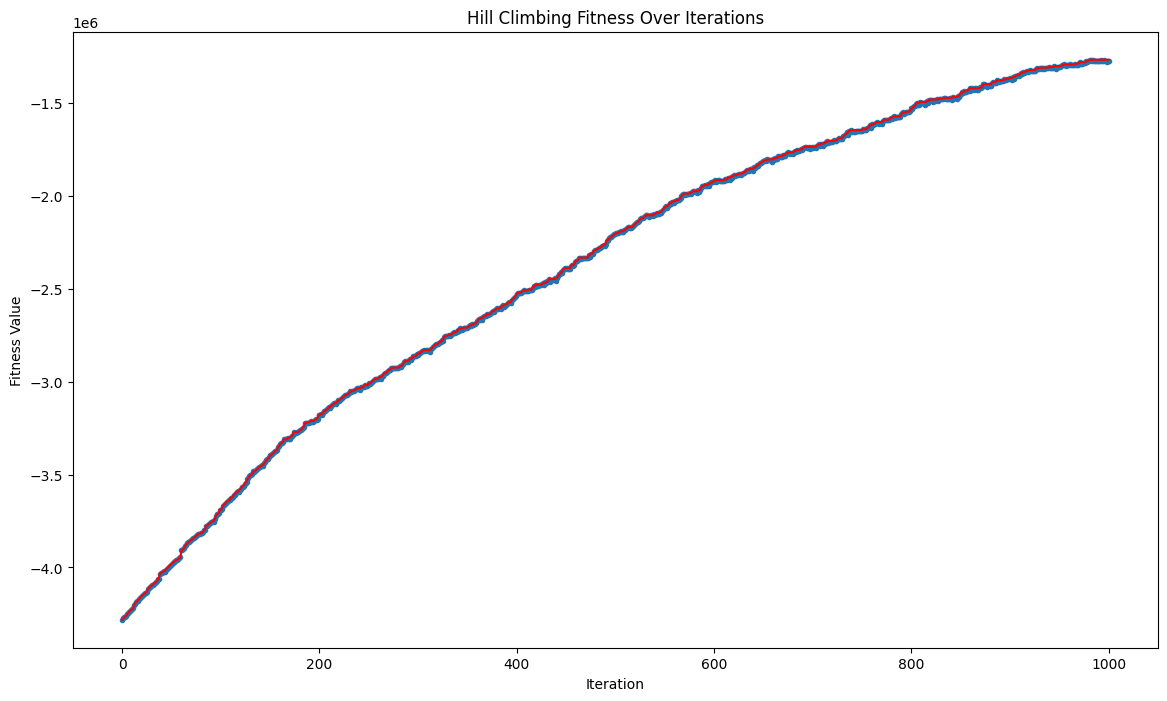

ic| valid(s): np.True_, cost(s): np.float64(1268063.0058698237)


In [962]:
s, history = hill_climbing(tweak_2, fitness_1, starting_point_1)

fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None

#### Multiple random mutations with second fitness and starting point

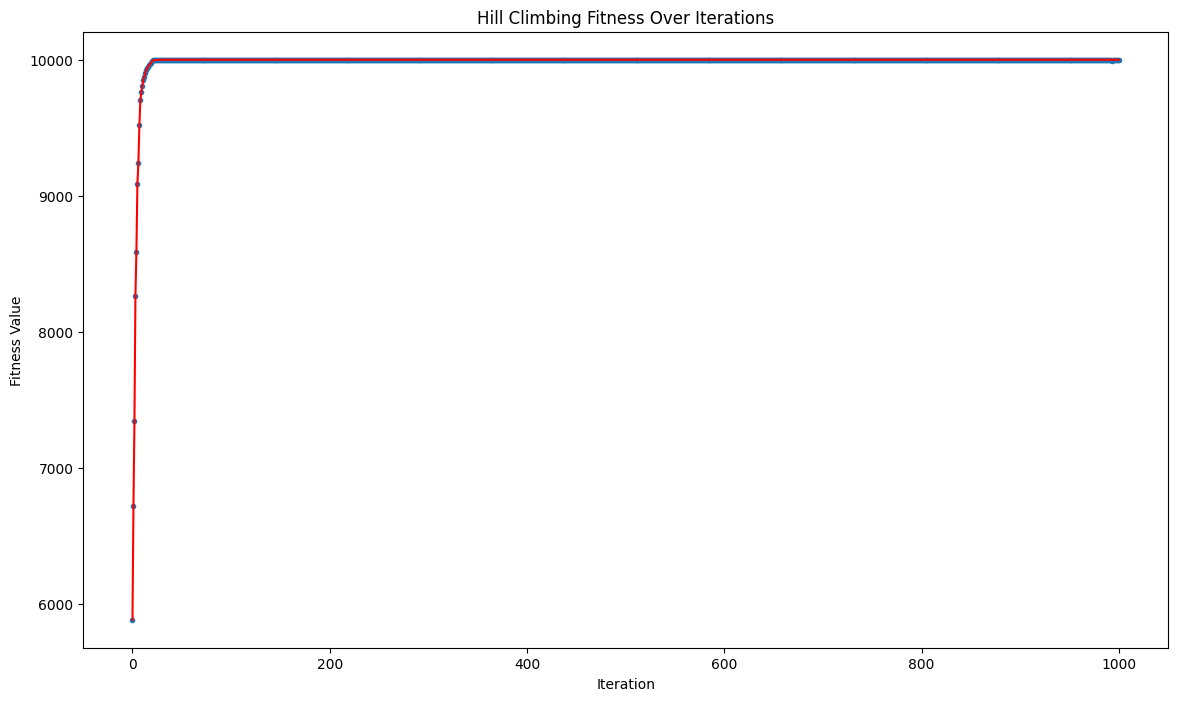

ic| valid(s): np.True_, cost(s): np.float64(131662.0397262389)


In [968]:
s, history = hill_climbing(tweak_2, fitness_2, starting_point_2)

fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None

### Hill Climbing - Steepest Step and Restart

In [964]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = max(stopping_criterion()) // STEEPEST_STEP_CANDIDATES

def steepest_step(solution, history, tweak=tweak_2, fitness=fitness_1):
    # Finds the best tweak among a set of candidates
    best_solution = solution
    best_fitness = fitness(solution)
    for _ in range(STEEPEST_STEP_CANDIDATES):
        candidate = tweak(solution)
        candidate_fitness = fitness(candidate)
        history.append(candidate_fitness)
        if candidate_fitness > best_fitness:
            best_solution = candidate
            best_fitness = candidate_fitness
    return best_solution

def hill_climbing_with_restarts(init_fitness, fitness, starting_point):
    # Performs hill climbing with multiple restarts
    best_solution = None
    best_fitness = init_fitness
    history = list()

    for _ in range(NUM_RESTARTS):
        solution = starting_point()
        history.append(fitness(solution))
        for _ in range(TRUE_MAX_STEPS // NUM_RESTARTS):
            new_solution = steepest_step(solution, history, fitness=fitness)
            if fitness(new_solution) > fitness(solution):
                solution = new_solution
        if fitness(solution) > best_fitness:
            best_solution = solution
            best_fitness = fitness(solution)
    return best_solution, history



#### Steepest Step and Restart with first fitness and starting point

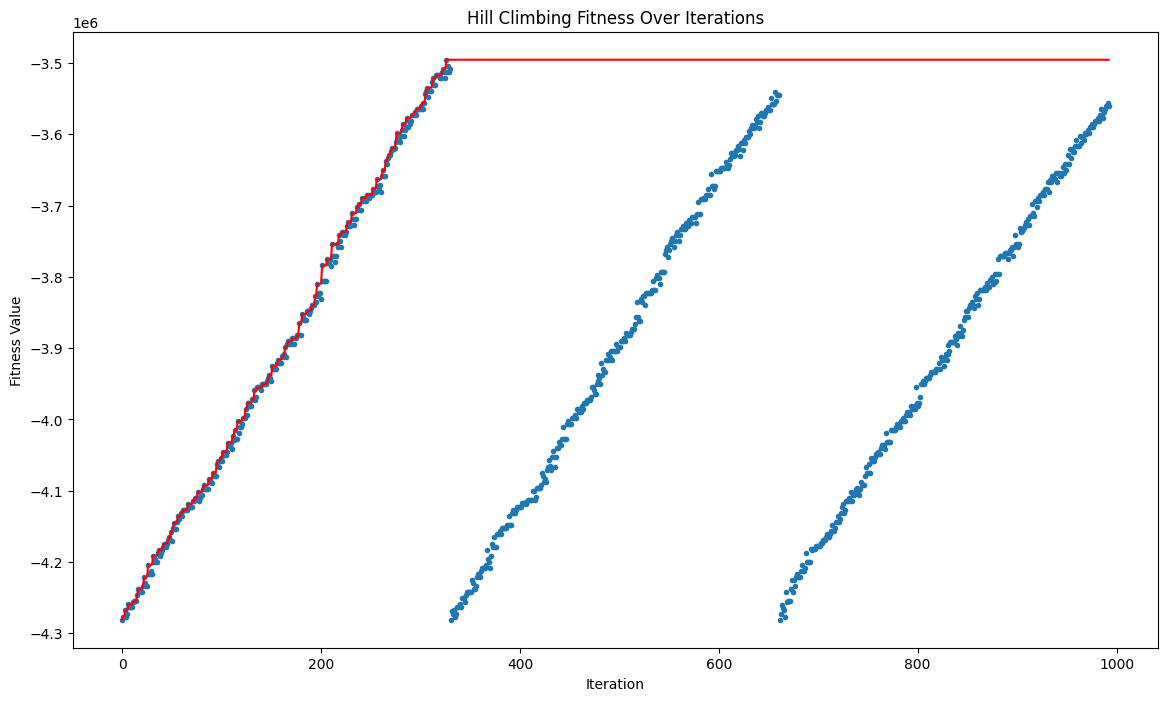

ic| valid(s): np.True_, cost(s): np.float64(3495443.1981065874)


In [965]:
init_fitness = (False, float('-inf'))
s, history = hill_climbing_with_restarts(init_fitness, fitness=fitness_1, starting_point=starting_point_1)

fitness_values = [second_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None

#### Steepest Step and Restart with second fitness and starting point

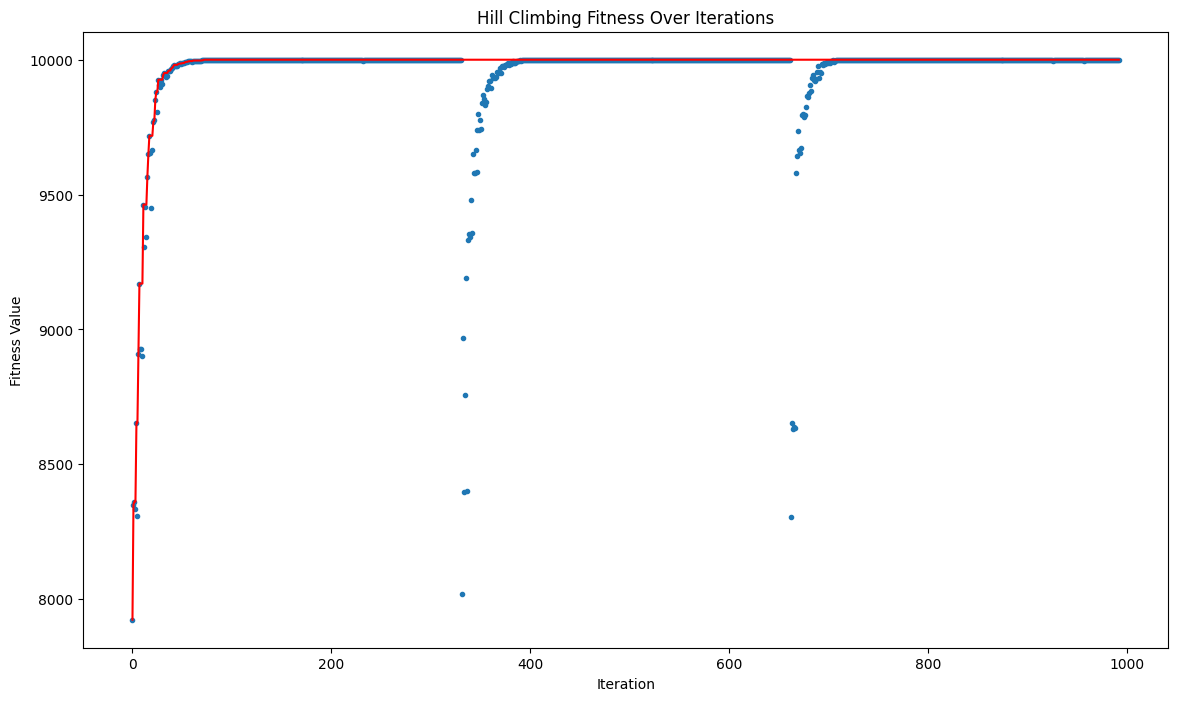

ic| valid(s): np.True_, cost(s): np.float64(146564.38928453266)


In [969]:
init_fitness = (0, float('-inf'))
s, history = hill_climbing_with_restarts(init_fitness, fitness=fitness_2, starting_point=starting_point_2)

fitness_values = [first_fitness_criterion for first_fitness_criterion, second_fitness_criterion in history]
fitness_plot(fitness_values)

ic(valid(s), cost(s))
None